# Wind power forecasting
### Kirill Zakharov
##### @kirillzx
2021

In [153]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge, LogisticRegression
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from fbprophet import Prophet

In [226]:
data = pd.read_csv('Turbine_Data.csv', parse_dates=True, index_col='Unnamed: 0')
data.index = pd.DatetimeIndex(data.index)
data = data.drop(['WTG', 'ControlBoxTemperature'], axis=1)
data = data.tz_localize(None)
names = data.columns
data.head(4)

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
2017-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-31 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-31 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-31 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [227]:
data = data.resample('H').last()

In [228]:
data.describe()

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
count,16383.000000,16220.000000,10697.000000,7237.000000,7247.000000,7247.000000,10699.000000,10665.000000,10666.000000,10665.000000,10672.000000,10701.000000,10699.000000,16040.000000,16370.000000,10666.000000,10838.000000,16040.000000,16329.000000
mean,621.305866,28.772380,42.767012,10.080176,10.421922,10.421922,63.889435,57.577229,1098.372017,72.632537,72.007971,36.681793,39.318667,200.589169,87.649538,9.848529,266.056653,200.589169,5.889907
std,613.848854,4.386854,6.368439,21.095460,20.876800,20.876800,11.443633,6.369424,536.098816,22.755491,22.786564,5.839204,6.370077,90.365835,116.744871,4.812315,1925.738150,90.365835,2.640692
min,-15.099586,0.000000,0.000000,-1.475139,-26.443415,-26.443415,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-94.458735,0.000000,0.000000,0.000000,0.000000
25%,76.958136,25.648923,39.747609,-0.942713,-0.444914,-0.444914,57.615364,53.908134,1029.783973,55.486944,54.756609,33.781169,35.695494,148.000000,-0.460284,9.230678,2.000000,148.000000,3.815980
50%,403.213985,28.361694,42.849427,0.378270,0.866934,0.866934,64.824585,57.232402,1126.948380,65.944966,65.184334,37.003815,39.456250,185.000000,34.614529,10.106193,2.000000,185.000000,5.565950
75%,1082.061853,31.649271,47.015323,8.358505,8.773079,8.773079,71.069947,61.411418,1523.164275,86.400077,85.901166,40.005394,43.268262,277.750000,146.209264,13.655760,2.000000,277.750000,7.550625
max,1749.253210,42.405597,55.005781,90.143610,90.017830,90.017830,82.093684,70.644781,1772.362500,126.500385,125.771160,47.996185,54.250000,357.000000,403.713620,15.901775,16384.000000,357.000000,22.172939


In [229]:
data.shape

(19704, 19)

In [230]:
data1 = data.dropna()
data1.describe()

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
count,6939.000000,6939.000000,6939.000000,6939.000000,6939.000000,6939.000000,6939.000000,6939.000000,6939.000000,6939.000000,6939.000000,6939.000000,6939.000000,6939.000000,6939.000000,6939.000000,6939.000000,6939.000000,6939.000000
mean,671.990369,28.378408,43.124857,10.119065,10.448041,10.448041,64.569276,57.693193,1120.257605,73.972730,73.331079,36.781204,39.556812,216.481559,132.027224,10.043676,355.574434,216.481559,6.118542
std,630.586453,4.083337,5.623176,21.206048,20.979108,20.979108,10.903789,7.054117,539.075465,24.078296,24.093965,4.872419,5.308153,95.555140,128.581219,4.842411,2282.316362,95.555140,2.712680
min,-11.070078,0.000000,0.000000,-1.475139,-26.443415,-26.443415,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-94.458735,0.000000,0.000000,0.000000,0.980240
25%,100.549451,25.408801,39.858858,-0.945052,-0.445932,-0.445932,58.179658,53.789275,1029.888635,55.907855,55.151577,33.768826,35.984856,162.400000,18.763329,9.232615,2.000000,162.400000,4.048007
50%,460.624167,27.858273,42.898660,0.365507,0.834804,0.834804,65.267444,57.284894,1147.193622,66.805358,66.031328,36.996185,39.393737,185.000000,90.680307,10.284238,2.000000,185.000000,5.775083
75%,1229.280467,31.096154,47.381611,8.384321,8.812305,8.812305,71.502884,62.143430,1566.602507,91.186190,90.616363,40.003815,43.063538,332.000000,238.967645,14.042206,2.000000,332.000000,7.884571
max,1749.253210,42.405597,55.005781,90.143610,90.017830,90.017830,82.093684,70.644781,1769.605500,126.500385,125.771160,47.996185,54.250000,357.000000,403.713620,15.869859,16384.000000,357.000000,20.127939


In [231]:
data2 = data.fillna(method='bfill')
data2.describe()

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
count,19704.000000,19704.000000,19704.000000,19704.000000,19704.000000,19704.000000,19704.000000,19704.000000,19704.000000,19704.000000,19704.000000,19704.000000,19704.000000,19704.000000,19704.000000,19704.000000,19704.000000,19704.000000,19704.000000
mean,618.222303,28.622117,44.034024,27.849926,28.012032,28.012032,67.953916,59.713738,1317.168478,85.586037,84.938884,37.746970,39.598684,200.048290,82.422057,11.808902,157.265631,200.048290,5.900689
std,607.135603,4.685761,7.038671,19.597386,19.427436,19.427436,12.603662,5.780909,503.721609,25.127014,25.116960,6.699125,6.423382,92.465277,112.727433,4.518243,1485.736921,92.465277,2.662741
min,-15.099586,0.000000,0.000000,-1.475139,-26.443415,-26.443415,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-94.458735,0.000000,0.000000,0.000000,0.000000
25%,81.136461,25.563779,41.386915,1.839120,2.265331,2.265331,62.520512,56.107035,1045.391865,61.832227,61.040086,34.991309,38.069271,138.000000,-0.535291,9.373904,2.000000,138.000000,3.851809
50%,406.150964,28.260779,45.529652,39.576077,39.576122,39.576122,72.399123,60.764425,1410.690222,88.073553,87.487088,38.240765,40.974950,185.000000,29.644156,12.623914,2.000000,185.000000,5.640460
75%,1041.253607,31.636117,47.901936,39.576077,39.576122,39.576122,77.119133,64.204399,1751.715563,113.290871,112.592163,42.996094,41.898426,281.800000,131.758683,15.708135,2.000000,281.800000,7.498115
max,1749.253210,42.405597,55.005781,90.143610,90.017830,90.017830,82.093684,70.644781,1772.362500,126.500385,125.771160,47.996185,54.250000,357.000000,403.713620,15.901775,16384.000000,357.000000,22.172939


In [232]:
data2.head()

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
2017-12-31 00:00:00,-4.756408,22.920777,47.901936,39.576077,39.576122,39.576122,77.119133,64.204399,1751.715563,113.290871,112.592163,42.996094,41.898426,345.0,-9.569932,15.708135,2.0,345.0,1.653846
2017-12-31 01:00:00,-4.756408,22.920777,47.901936,39.576077,39.576122,39.576122,77.119133,64.204399,1751.715563,113.290871,112.592163,42.996094,41.898426,345.0,-9.569932,15.708135,2.0,345.0,1.653846
2017-12-31 02:00:00,-4.756408,22.920777,47.901936,39.576077,39.576122,39.576122,77.119133,64.204399,1751.715563,113.290871,112.592163,42.996094,41.898426,345.0,-9.569932,15.708135,2.0,345.0,1.653846
2017-12-31 03:00:00,-4.756408,22.920777,47.901936,39.576077,39.576122,39.576122,77.119133,64.204399,1751.715563,113.290871,112.592163,42.996094,41.898426,345.0,-9.569932,15.708135,2.0,345.0,1.653846
2017-12-31 04:00:00,-4.756408,22.920777,47.901936,39.576077,39.576122,39.576122,77.119133,64.204399,1751.715563,113.290871,112.592163,42.996094,41.898426,345.0,-9.569932,15.708135,2.0,345.0,1.653846


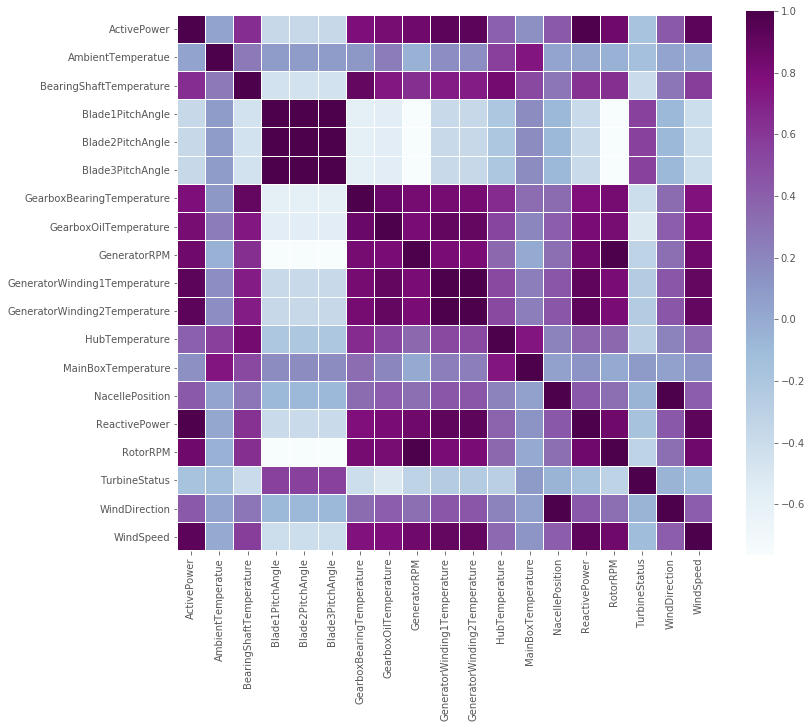

In [233]:
fig = plt.figure(figsize=(12,10))

sns.heatmap(data1.corr(), annot=False, cmap='BuPu', square=True, linewidth=0.01)
b1,t1=plt.ylim()
b1+=0.5
t1-=0.5
plt.ylim(b1, t1)
plt.show()

## Model with all features

In [148]:
X = data1[names[1:]]
Y = data1.iloc[:, 0]
validation_size = 0.33
seed = 5
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [149]:
model = LinearRegression()
# scoring = 'neg_mean_squared_error'
scoring = 'neg_mean_absolute_error'
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
cv = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
cv.mean()

-48.31923014376756

In [150]:
model.fit(X_train, Y_train)
forecast = model.predict(X_test)

In [162]:
#r2
model.score(X_train, Y_train)

0.9802582812602504

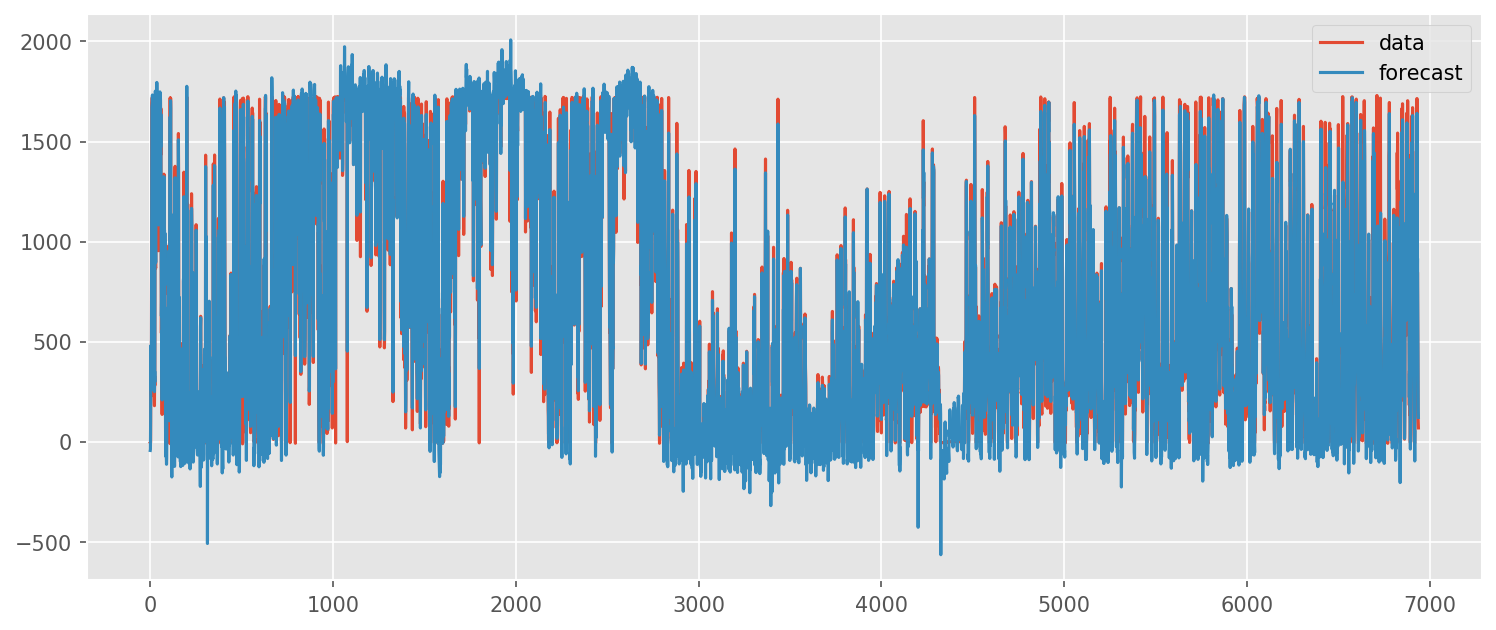

In [151]:
plt.subplots(figsize=(12, 5), dpi=150)
plt.plot(data1.iloc[:, 0].values, label='data')
plt.plot(model.predict(data1.iloc[:, 1:]), label='forecast')
plt.legend()
plt.show()

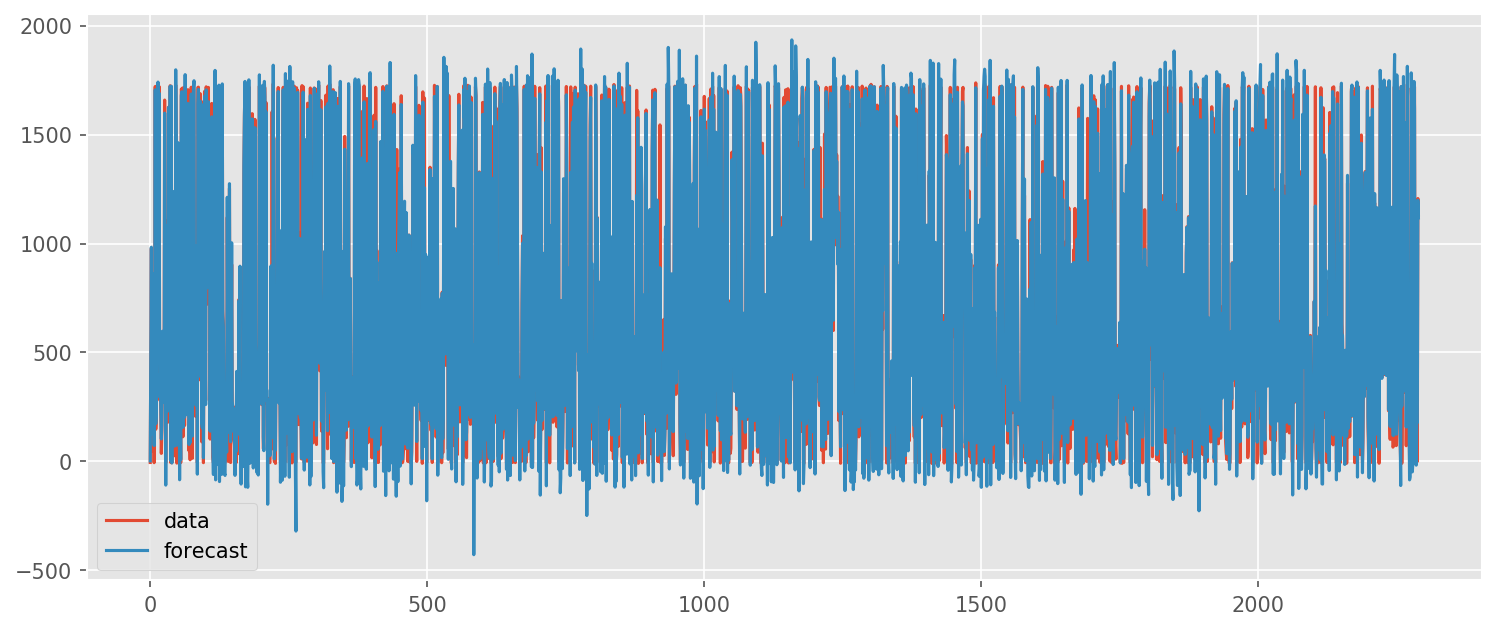

In [152]:
plt.subplots(figsize=(12, 5), dpi=150)
plt.plot(Y_test.values, label='data')
plt.plot(model.predict(X_test), label='forecast')
plt.legend()
plt.show()

### Ridge

In [155]:
model = Ridge()
# scoring = 'neg_mean_squared_error'
scoring = 'neg_mean_absolute_error'
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
cv = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
cv.mean()

-48.26876587751601

In [156]:
model.fit(X_train, Y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [157]:
#r2
model.score(X_train, Y_train)

0.9802582812602504

In [158]:
#r2
model.score(X_test, Y_test)

0.9775938302590866

In [159]:
forecast = model.predict(X_test)

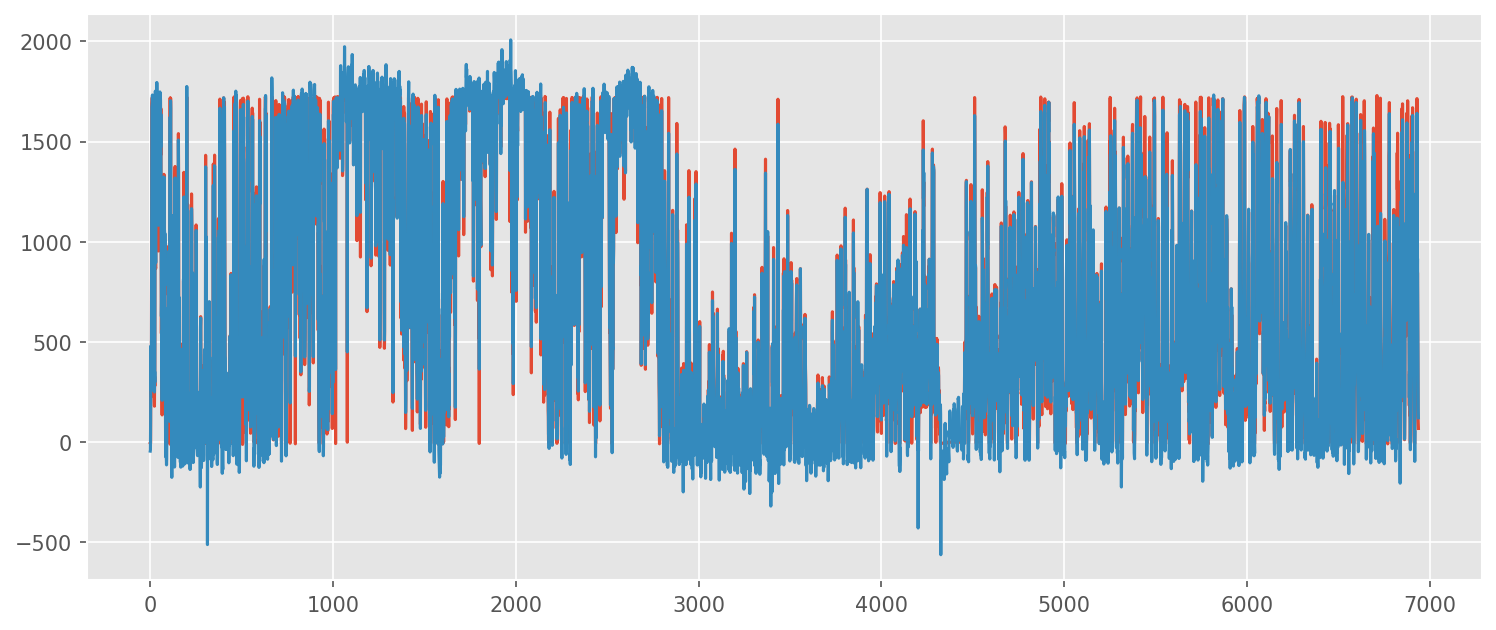

In [160]:
plt.subplots(figsize=(12, 5), dpi=150)
plt.plot(data1.iloc[:, 0].values)
plt.plot(model.predict(data1.iloc[:, 1:]))
plt.show()

## Model with wind speed and wind direction features

In [206]:
X = data1.iloc[:, -2:]
Y = data1.iloc[:, 0]
validation_size = 0.33
seed = 5
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [208]:
model = LinearRegression()
# scoring = 'neg_mean_squared_error'
scoring = 'neg_mean_absolute_error'
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
cv = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
cv.mean()

-161.4130459213596

In [209]:
model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

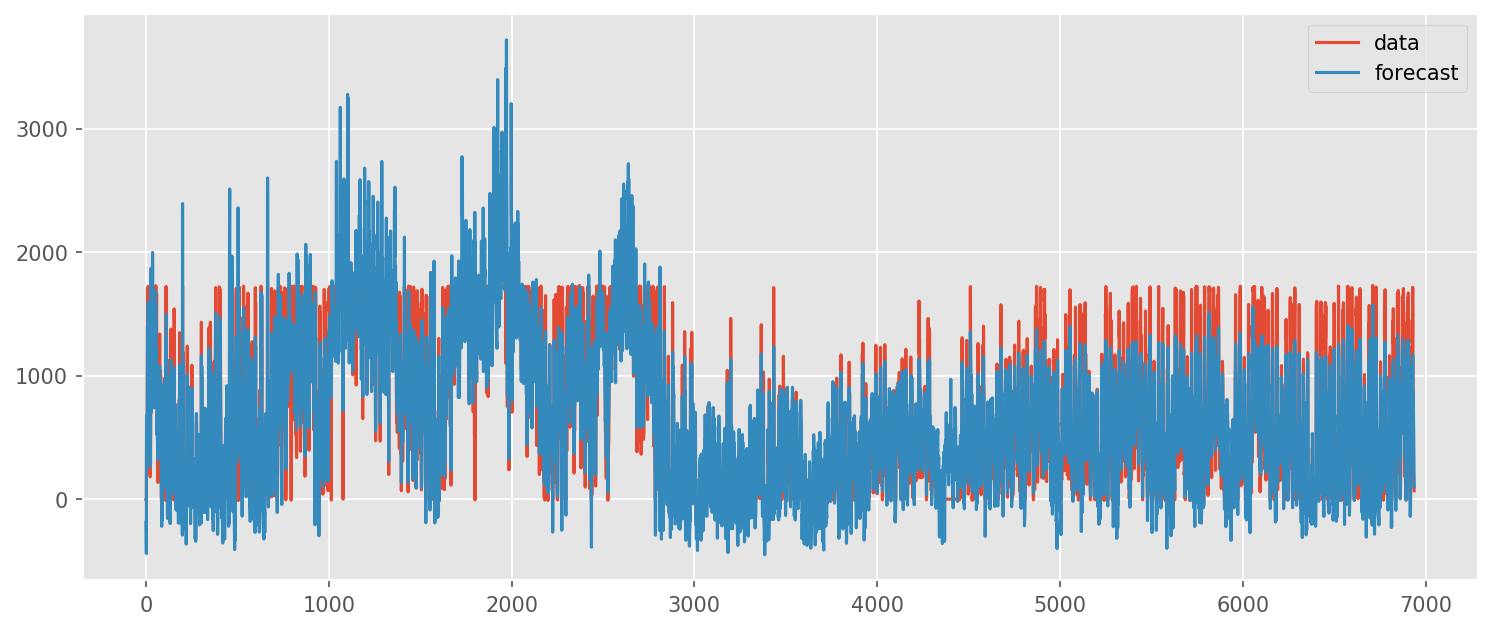

In [212]:
plt.subplots(figsize=(12, 5), dpi=150)
plt.plot(data1.iloc[:, 0].values, label='data')
plt.plot(model.predict(data1.iloc[:, -2:]), label='forecast')
plt.legend()
plt.show()

In [234]:
data_prophet = data1[['WindSpeed']]
data_prophet = data_prophet.reset_index()
data_prophet.columns = ['ds', 'y']
data_prophet.head()

,ds,y
0,2019-05-06 14:00:00,2.347810
1,2019-05-06 15:00:00,1.909285
2,2019-05-06 16:00:00,1.155865
3,2019-05-06 17:00:00,6.065840
4,2019-05-06 18:00:00,5.229805


In [235]:
model1 = Prophet(weekly_seasonality=False, daily_seasonality=False)
model1.fit(data_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [236]:
future = model1.make_future_dataframe(periods=14, freq='D')

In [237]:
forecast = model1.predict(future)

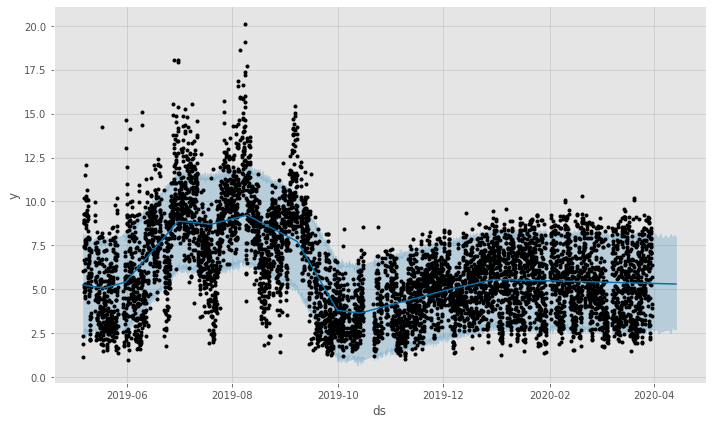

In [238]:
model1.plot(forecast)
plt.show()

In [239]:
wind_forecast = forecast['yhat'].values[-14:]
wind_forecast

array([5.33318119, 5.33070067, 5.32822016, 5.32573964, 5.32325913,
       5.32077861, 5.3182981 , 5.31581758, 5.31333706, 5.31085655,
       5.30837603, 5.30589552, 5.303415  , 5.30093449])

In [242]:
data_prophet = data1[['WindDirection']]
data_prophet = data_prophet.reset_index()
data_prophet.columns = ['ds', 'y']
model1 = Prophet(weekly_seasonality=False, daily_seasonality=False)
model1.fit(data_prophet)
future = model1.make_future_dataframe(periods=14, freq='D')
forecast = model1.predict(future)
windD_forecast = forecast['yhat'].values[-14:]
windD_forecast

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


array([183.20853513, 183.32153666, 183.4345382 , 183.54753973,
       183.66054127, 183.7735428 , 183.88654434, 183.99954587,
       184.1125474 , 184.22554894, 184.33855047, 184.45155201,
       184.56455354, 184.67755508])

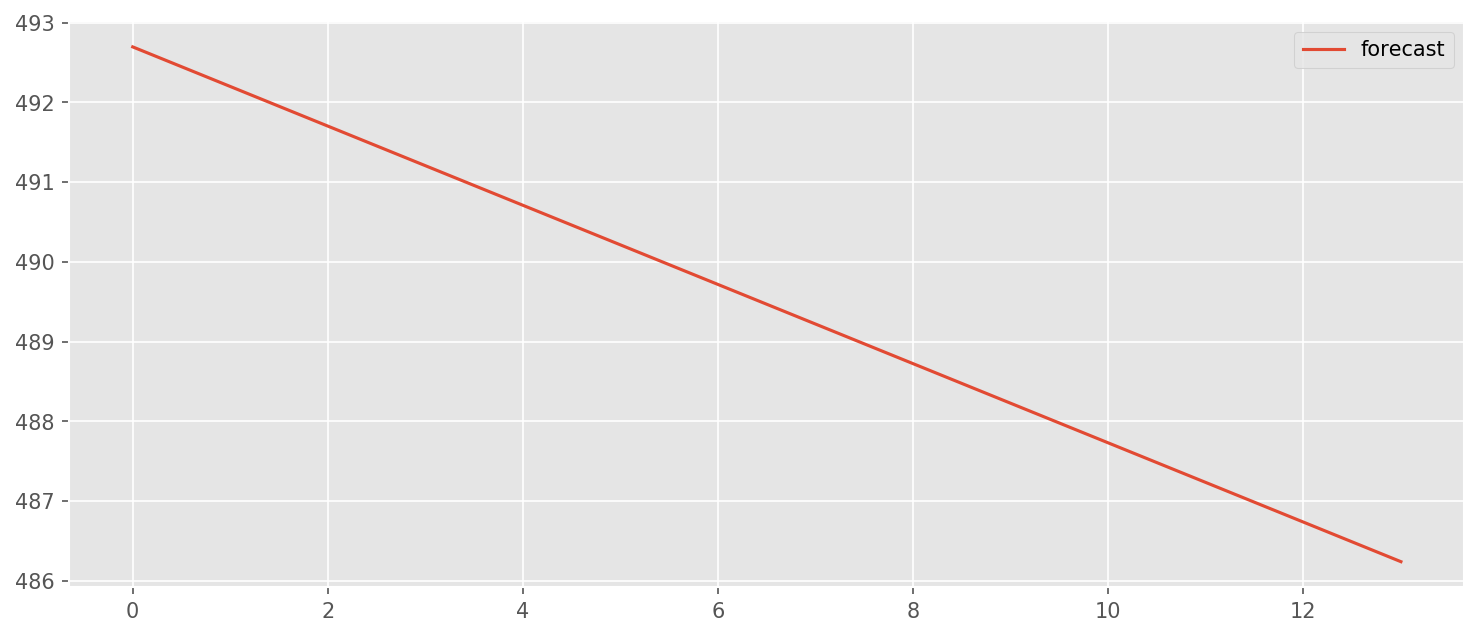

In [249]:
plt.subplots(figsize=(12, 5), dpi=150)
# plt.plot(data1.iloc[:, 0].values, label='data')
plt.plot(model.predict(np.array([windD_forecast,wind_forecast]).T), label='forecast')
plt.legend()
plt.show()